# Case 1 - Student notebook

Welcome to the helper notebook for case 1. This notebook contains prepared code that you can use to tackle case 1. Specifically, you can find here:

- Code to load the case data.
- Simulation tools to test warehouse purchasing policies.

This notebook is designed to be used in Google Colab. You can also export it and run it in any other Jupyter Notebook environment, but a thing or two will probably break and you will need to fix them yourself. Your choice.

## Imports and Data loading

In [100]:
# Import all the necessary packages
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import kurtosis, skew, jarque_bera, probplot, gaussian_kde

In [487]:
# Upload files from your computer here
# Run the cell and click the "Browse" button to upload the provided CSV
demand = pd.read_csv("./ps_data/demand_events.csv", parse_dates=["date"])
sourcing = pd.read_csv("./ps_data/sourcing_events.csv", parse_dates=["request_date", "delivery_date"])
stock = pd.read_csv("./ps_data/stock_state.csv", parse_dates=["date"])

first_level_second_sim = pd.read_csv("./first_level/second_sim.csv")
first_level_third_sim = pd.read_csv("./first_level/third_sim.csv")
second_level_first_sim = pd.read_csv("./second_level/first_sim.csv")
third_level_first_sim = pd.read_csv("./third_level/first_sim.csv")
third_level_second_sim = pd.read_csv("./third_level/second_sim.csv")
third_level_all_sim = pd.read_csv("./third_level/all_data.csv", sep = ";", decimal = ",")

# Checking that all data types are correct and printing the name of the variables
demand.info(), \
sourcing.info(), \
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             365 non-null    datetime64[ns]
 1   demand_quantity  365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   request_date   60 non-null     datetime64[ns]
 1   delivery_date  60 non-null     datetime64[ns]
 2   amount         60 non-null     float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 1.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         

(None, None, None)

## Level 1

From the case description:

    - Elisa wants you to measure the performance of the last year, providing
      quantitative metrics. She knows it was a bad year, but hasn't looked at
      the real data to summarize how bad it was. Remember that there is a
      trade-off: too much stock, is not desired, but running out of stock and making
      clients wait is also negative.
    - Going one step further, Elisa wants to know: what was done wrong?

Use this section to visualize/analyse data from last year to answer Elisa's request.

In [20]:
sourcing["lead_time"] = sourcing.delivery_date - sourcing.request_date
sourcing.head()

,request_date,delivery_date,amount,lead_time
0,2021-06-18,2021-06-24,361622.084212,6 days
1,2021-04-08,2021-04-17,404943.208184,9 days
2,2021-08-02,2021-08-10,372079.374931,8 days
3,2021-03-23,2021-03-28,324410.868370,5 days
4,2021-07-14,2021-07-19,467167.833054,5 days


In [21]:
# Demand monthly breakdown (daily mean and total monthly demand)

monthly_demand = demand.groupby(demand.date.dt.month)["demand_quantity"].agg(["mean", "sum"])
monthly_demand

,mean,sum
date,,
1,54892.957554,1.701682e+06
2,50593.354843,1.416614e+06
3,47470.785933,1.471594e+06
4,55327.473371,1.659824e+06
5,48340.006555,1.498540e+06
6,50400.161789,1.512005e+06
7,46866.598172,1.452865e+06
8,47065.905734,1.459043e+06
9,49102.400819,1.473072e+06


In [22]:
# Total of 60 POs

lead_time_freq = pd.concat(
    [
    round(sourcing.lead_time.value_counts(normalize=True)*100, 2).sort_index(),
    sourcing.lead_time.value_counts()
    ],
    axis=1,
    keys=('perc','count'))

lead_time_freq
# HACER MEDIA PONDERADA

# 95% of POs are served within the first 10 days

,perc,count
4 days,3.33,2
5 days,18.33,11
6 days,11.67,7
7 days,21.67,13
8 days,16.67,10
9 days,18.33,11
10 days,5.00,3
11 days,3.33,2
12 days,1.67,1


In [628]:
lead_time_num = list()
for i in range(len(sourcing.lead_time)):
    lead_time_num.append(sourcing.lead_time[i].days)
lead_time_num = pd.Series(lead_time_num)

AttributeError: 'DataFrame' object has no attribute 'lead_time'

In [24]:
jarque_bera(lead_time_num)

Jarque_beraResult(statistic=1.2551691618247631, pvalue=0.5338797882972981)

In [418]:
# Stockout

print(round((len(stock.amount_in_stock[stock["amount_in_stock"] < 0]) / len(stock["amount_in_stock"])*100), 2),"%")

24.38 %


In [420]:
len(stock.amount_in_stock[stock["amount_in_stock"] < 0]) * demand.demand_quantity.mean()

4463278.446953098

In [26]:
demand.demand_quantity.describe()

count       365.000000
mean      50149.196033
std       14220.766342
min        1380.989899
25%       40200.061511
50%       50873.130777
75%       59385.010216
max      107790.972360
Name: demand_quantity, dtype: float64

In [421]:
demand.demand_quantity.quantile(np.linspace(0,1,11))

0.0      1380.989899
0.1     31870.524043
0.2     37850.645910
0.3     42499.912673
0.4     46563.191554
0.5     50873.130777
0.6     53905.276781
0.7     57407.987082
0.8     61641.077256
0.9     67098.799172
1.0    107790.972360
Name: demand_quantity, dtype: float64

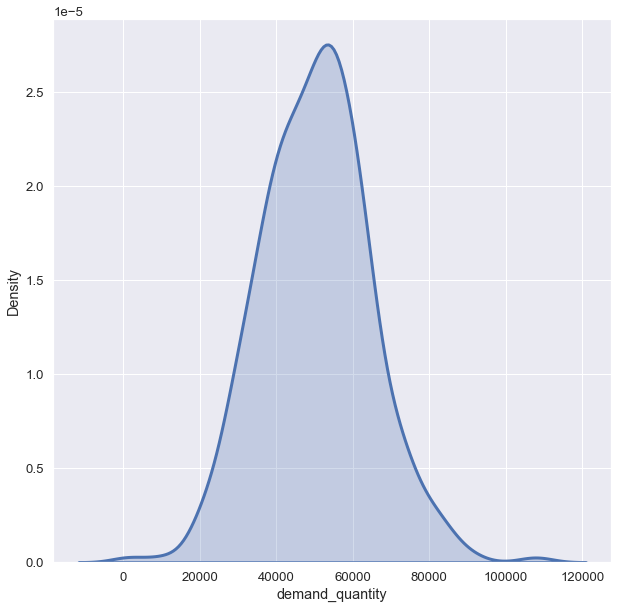

In [437]:
sns.set(rc={"figure.figsize":(10, 10)}, font_scale = 1.2)
sns.kdeplot(demand.demand_quantity, fill = True, lw = 3);

In [438]:
demand.demand_quantity.mean(), demand.demand_quantity.std()

(50149.19603318088, 14220.766341787914)

In [29]:
kurtosis(demand.demand_quantity)

0.591301018958382

In [30]:
skew(demand.demand_quantity)

0.15865466732062683

<AxesSubplot:xlabel='demand_quantity', ylabel='Proportion'>

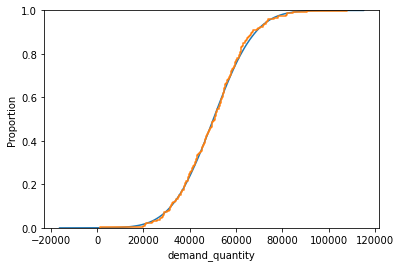

In [31]:
theoretical_normal_ecdf = np.random.normal(demand.demand_quantity.mean(), demand.demand_quantity.std(), 1000000)
sns.ecdfplot(theoretical_normal_ecdf)
sns.ecdfplot(demand.demand_quantity)

#Orange is empirical data, blue is a theoretical normal kde with the same mean and sd as the emprical distribution

In [32]:
# Testing for normality

jarque_bera(demand.demand_quantity)

# It's not a normal distribution, the kurtosis is too low. But we will assume it behaves as one because it's fairly close.

Jarque_beraResult(statistic=6.848648739090377, pvalue=0.03257127970528639)

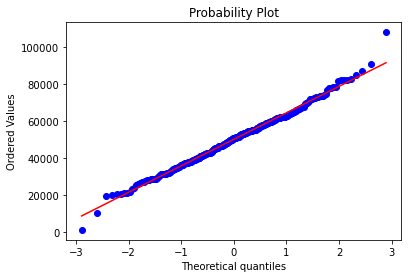

In [33]:
# QQplot

probplot(demand.demand_quantity, plot = pylab);

In [34]:
# We assume a normal distribution. Although the JB test indicates otherwise, it's not too far off.

top, bottom = demand.demand_quantity.mean() + 1.96 * demand.demand_quantity.std()/np.sqrt(demand.demand_quantity.count()), \
              demand.demand_quantity.mean() - 1.96 * demand.demand_quantity.std()/np.sqrt(demand.demand_quantity.count())

print(top, bottom)

51608.119936148956 48690.272130212805


In [35]:
# We look at the CI when transforming stock to days of stock

stock_in_days_pessimistic, stock_in_days_optimistic, stock_in_days_mean = stock.amount_in_stock / top, \
                                                                          stock.amount_in_stock / bottom, \
                                                                          stock.amount_in_stock / demand.demand_quantity.mean()

# There's about 0.4 days (in average) between the bottom and top brackets, so using the point estimate will give us a fairly good approximation
(stock_in_days_optimistic - stock_in_days_pessimistic).mean()

0.4179592852487746

In [627]:
pd.concat([sourcing.request_date.groupby(sourcing.date.dt.month).agg([len]),
           stock.amount_in_stock.groupby(stock.date.dt.month).agg([np.mean])],
           axis = 1)

,len,mean
date,,
1,7,4.981886e+05
2,4,8.999950e+05
3,4,4.029861e+05
4,6,1.955892e+05
5,2,3.601396e+05
6,8,-4.238066e+04
7,6,5.214447e+05
8,5,1.100830e+06
9,2,7.172012e+05


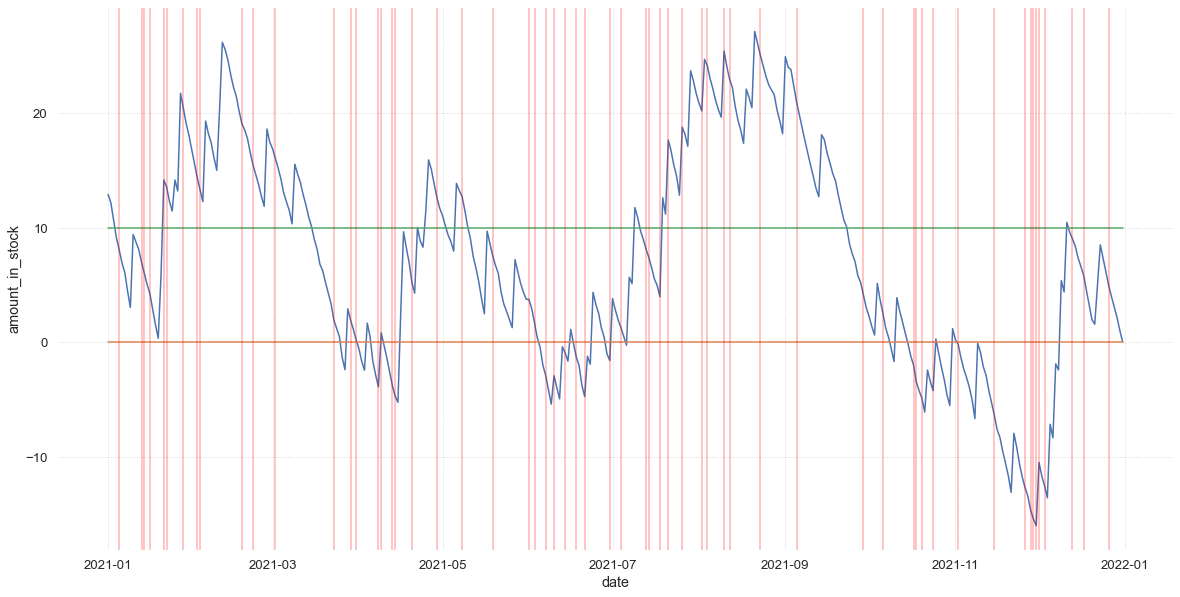

In [610]:
sns.lineplot(x = stock.date, y = stock_in_days_mean)

# Line at the 0 and 10 days cutoff
# The 10 day cutoff satisfies 95% of the POs served (code chunk #4)

sns.lineplot(y = 0, x = stock.date)
sns.lineplot(y = 10, x = stock.date)

# Plotting all days where there an order
for i in range(0, len(sourcing.request_date)):
    plt.axvline(x=sourcing.request_date[i], color = "red", alpha = 0.3)

In [37]:
# select the days where there was more stock than needed

stock_surplus =  stock[stock_in_days_mean > 10].mean()
ten_days_demand = 10 * demand.demand_quantity.mean()

# In average, the amount in $ of overstock for the days where there was stock surplus
stock_surplus - ten_days_demand

<ipython-input-37-e72162fc2ca2>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  stock_surplus =  stock[stock_in_days_mean > 10].mean()


amount_in_stock    356018.010413
dtype: float64

## Level 2

From the case description:

    - Elisa wants you to propose an ordering policy. This means, that you need
      to define a rule that, once each day, should answer the questions: should
      be place an order to request material today? If yes, how much should we
      order?
    - Use simulation to present metrics on what is the expected performance
      with the policy you are proposing. Remember, you need to convince Elisa
      that this is better than what happens today.
    - As a specific constraint, Elisa explains that she wants that the
      probability of a stockout to be at most of 5% on any given day.

Use this Level 2 section to learn how to use the provided code and run your own analysis and simulations to answer Elisa's request.

In [39]:
# Si se puede: hacer una simulación empezando con el stock de 2021 y cortar las primeras dos semanas de la simulación. Así es un numero de starting stock aleatorio pero a la vez consistente con nuestra política de compras.

# Opción 2. Empezar con un stock aleatorio que satisfaga demanda entre 7 y 10 días.

### Prepared simulation code

To help you out, I have prepared some code that will assist you in running simulations. The cells below contain the code and a small example showing you how to use.

In [40]:
# This is the helper code. Run the cell to load it.

base = datetime(2022,1,1)
dates_in_2022 = [base + timedelta(days=x) for x in range(365*500 + 21)]

class SimulationResult:

  def __init__(self, stock_states, demand_by_day, sourcing_events):
    self.stock_states = stock_states
    self.demand_by_day = demand_by_day
    self.sourcing_events = sourcing_events

  def plot_stock_history(self):
    sns.lineplot(x=dates_in_2022, y=self.stock_states)

  def plot_stock_distribution(self):
    sns.histplot(x=self.stock_states, kde=True)

  def service_level(self):
    return (self.stock_states > 0 ).astype(int).mean()

  def stock_level_summary(self):
    print(
        pd.DataFrame(self.stock_states).describe()
    ) 
    
  def mean_stock_level(self):
    return self.stock_states.mean()

  def median_stock_level(self):
    return np.median(self.stock_states)

  def stdev_stock_level(self):
    return self.stock_states.std()

  def mean_demand(self):
    return self.demand_by_day.mean()
  
  def number_of_purchase_orders_placed(self):
    return len(self.sourcing_events)


class SimulationConfig:

  def __init__(self, starting_stock, demand_generator, lead_time_generator, purchaser, po_trigger, goal_stock):
    self.starting_stock = starting_stock
    self.demand_generator = demand_generator
    self.lead_time_generator = lead_time_generator
    self.purchaser = purchaser
    self.po_trigger = po_trigger
    self.goal_stock = goal_stock


class PurchaseOrder:
  
  def __init__(self, amount, request_date, delivery_date):
    self.amount = amount
    self.request_date = request_date
    self.delivery_date = delivery_date

  def __repr__(self):
    return f"Order of {self.amount:.0f}, requested on {self.request_date}, delivery on {self.delivery_date}."


class Simulation:
  
  def __init__(self, config: SimulationConfig, verbose=False):
    self._config = config
    self.verbose = verbose

  def run(self):

    stock_states = np.array([self._config.starting_stock])
    opened_orders = []
    ongoing_orders = {}
    demand_by_day = np.array(list())
  
    for day in dates_in_2022:
      if self.verbose:
        print(f"Simulating day: {day}")
      current_stock = stock_states[-1]
      if self.verbose:
        print(f"Starting stock: {current_stock:.0f}")
      demand_for_this_day = self._config.demand_generator()
      if self.verbose:
        print(f"Generated demand for today: {demand_for_this_day:.0f}")
      demand_by_day = np.append(demand_by_day, [demand_for_this_day])
      goods_received_this_day = 0
      if day in ongoing_orders:
        order_delivered_today = ongoing_orders.pop(day)
        goods_received_this_day = order_delivered_today.amount
      if self.verbose:
        print(f"Goods received today: {goods_received_this_day:.0f}")

      current_stock = current_stock + goods_received_this_day - demand_for_this_day
      stock_states = np.append(stock_states, [current_stock])


      order_to_make = self._config.purchaser(
          day, 
          current_stock, 
          ongoing_orders,
          self._config.lead_time_generator,

          # Variables to change each iteration
          self._config.po_trigger,
          self._config.goal_stock
      )

      if order_to_make:
        if self.verbose:
          print(f"Placing a new order: {order_to_make}")
        opened_orders.append(order_to_make)
        ongoing_orders[order_to_make.delivery_date] = order_to_make
    
    stock_states = np.delete(stock_states, 0) # Remove starting stock
    
    self.results = SimulationResult(
        stock_states=stock_states, 
        demand_by_day=demand_by_day, 
        sourcing_events=opened_orders   
    )

    return self.results



#### Simulation

##### Creating classes to simulate demand, lead time

##### Lead time generation

In [41]:
def generate_lead_time(g_min, g_max):

    generated_lead_time = int(np.random.normal(lead_time_num.mean(), lead_time_num.std()))

    while generated_lead_time < g_min or generated_lead_time > g_max:
        generated_lead_time = int(np.random.normal(lead_time_num.mean(), lead_time_num.std()))

    return generated_lead_time

##### Checking that the simulated demand distribution is similar to the empirical data

<AxesSubplot:ylabel='Density'>

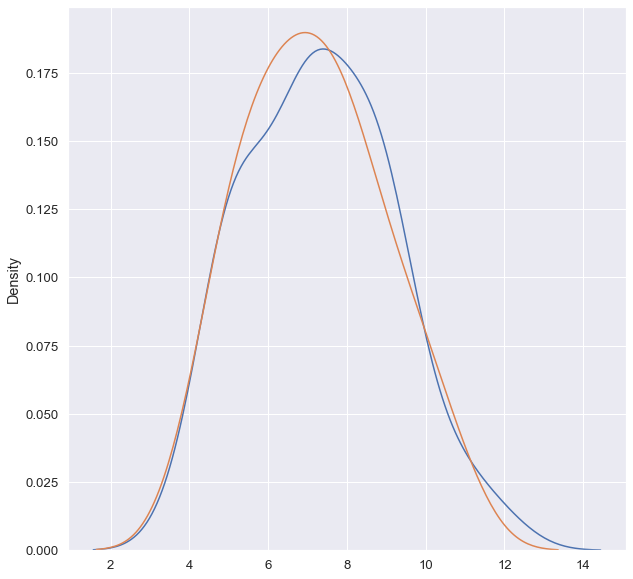

In [450]:
resample_lead_time = list()

for i in range(60):
    resample_lead_time.append(generate_lead_time(4,12))

sns.kdeplot(lead_time_num)
sns.kdeplot(resample_lead_time)

# Blue is empirical, orange is the resampling data

In [451]:
pd.concat([pd.Series(resample_lead_time).describe(),
           pd.Series(lead_time_num).describe()],
          axis = 1,
          keys = ("simulated", "empirical"))

,simulated,empirical
count,60.000000,60.000000
mean,7.166667,7.316667
std,1.786642,1.845670
min,4.000000,4.000000
25%,6.000000,6.000000
50%,7.000000,7.000000
75%,8.000000,9.000000
max,11.000000,12.000000


##### Demand generation

In [44]:
def generate_demand(g_min, g_max):
    generated_demand = float(np.round(gaussian_kde(demand.demand_quantity).resample(1)))

    while generated_demand < g_min or generated_demand > g_max:
        generated_demand = float(np.round(gaussian_kde(demand.demand_quantity).resample(1)))

    return generated_demand

##### Checking that the simulated demand distribution is similar to the empirical data

In [467]:
resample_demand = list()
for i in range(365):
    resample_demand.append(generate_demand(1000, 110000))

In [468]:
pd.concat([pd.Series(resample_demand).describe(),
           demand.demand_quantity.describe()],
          axis = 1,
          keys = ("simulated", "empirical"))

,simulated,empirical
count,365.000000,365.000000
mean,49968.495890,50149.196033
std,15295.051714,14220.766342
min,2392.000000,1380.989899
25%,39358.000000,40200.061511
50%,51202.000000,50873.130777
75%,59796.000000,59385.010216
max,101505.000000,107790.972360


<AxesSubplot:xlabel='demand_quantity', ylabel='Density'>

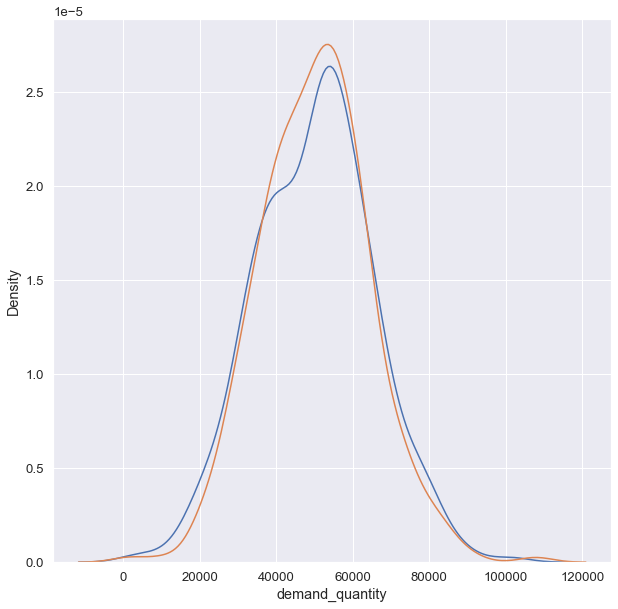

In [469]:
sns.kdeplot(resample_demand)
sns.kdeplot(demand.demand_quantity)

# Blue is resample, orange is empirical

In [48]:
# The Simulation class is the code that actually runs a simulation. It takes a 
# SimulationConfig as an input, and returns a SimulationResult as an output.
def purchase_policy(day,
                    current_stock,
                    ongoing_orders,
                    lead_time_generator,
                    po_trigger,
                    goal_stock
                    ):

    if ongoing_orders or current_stock > po_trigger:
        return None

    if current_stock <= po_trigger:
        return PurchaseOrder(
            amount = goal_stock - current_stock,
            request_date = day,
            delivery_date = day + timedelta(days = lead_time_generator()),
        )

In [65]:
import time

now = time.time()

mean_demand_quantity = demand.demand_quantity.mean()

tracking = list()
po_trigger_tracking = list()
goal_tracking = list()
mean_stock_tracking = list()
availability_rate_tracking = list()

for trigger in np.linspace(4, 12, 17):
    for goal in np.linspace(4, 12, 17):
        if goal <= trigger:
            continue
        simulation_config = SimulationConfig(
            starting_stock = stock.amount_in_stock.iloc[-1],
            demand_generator = lambda: generate_demand(1000, 110000),
            lead_time_generator = lambda: generate_lead_time(4,12),
            purchaser = purchase_policy,
            po_trigger = mean_demand_quantity * trigger,
            goal_stock = mean_demand_quantity * goal
        )


        first_simulation = Simulation(
            config=simulation_config,
            verbose=False
        )
        example_simulation_results = first_simulation.run()

        tracking.append([trigger, goal])
        po_trigger_tracking.append(trigger)
        goal_tracking.append(goal)
        example_simulation_results_sliced = example_simulation_results.stock_states[21:]
        mean_stock_tracking.append(example_simulation_results_sliced.mean())
        availability_rate_tracking.append(len(example_simulation_results_sliced[example_simulation_results_sliced < 0]) / len(example_simulation_results.stock_states))

time.time() - now

11984.35780096054

In [95]:
import time

now = time.time()

mean_demand_quantity = demand.demand_quantity.mean()

tracking = list()
po_trigger_tracking = list()
goal_tracking = list()
mean_stock_tracking = list()
availability_rate_tracking = list()

for trigger in range(8, 20):
    for goal in np.linspace(16,24,41):
        if goal <= trigger + 4: # The goal stock needs to account for at least the minimum lead time (4). All other simulations are trivial because the stock wouldn't be in the warehouse in time.
            continue
        simulation_config = SimulationConfig(
            starting_stock = stock.amount_in_stock.iloc[-1],
            demand_generator = lambda: generate_demand(1000, 110000),
            lead_time_generator = lambda: generate_lead_time(4,12),
            purchaser = purchase_policy,
            po_trigger = mean_demand_quantity * trigger,
            goal_stock = mean_demand_quantity * goal
        )


        simulation_setup = Simulation(
            config=simulation_config,
            verbose=False
        )
        example_simulation_results = simulation_setup.run()

        tracking.append("[" + f"{trigger}" +"," + f"{goal}" + "]")
        po_trigger_tracking.append(trigger)
        goal_tracking.append(goal)
        example_simulation_results_sliced = example_simulation_results.stock_states[21:]
        mean_stock_tracking.append(example_simulation_results_sliced.mean())
        availability_rate_tracking.append(len(example_simulation_results_sliced[example_simulation_results_sliced < 0]) / len(example_simulation_results.stock_states))

sim_run_time = time.time() - now

third_simulation = pd.DataFrame({
    "iteration_tracking" : tracking,
    "availability_rate" : availability_rate_tracking,
    "mean_stock" : mean_stock_tracking,
})

third_simulation.to_csv("./first_level/third_sim.csv", index = False)
(sim_run_time / 60) / 60 # Hours it took to simulate

8.559126335250006

In [355]:
sim_data = first_level_third_sim.copy()
sim_data.availability_rate = 1 - sim_data.availability_rate
sim_data["price_per_sl"] = sim_data.mean_stock / (sim_data.availability_rate * 100)
sim_data

,iteration_tracking,availability_rate,mean_stock,price_per_sl
0,"[8,16.0]",0.946434,257551.495249,2721.284471
1,"[8,16.2]",0.949376,264609.599064,2787.195863
2,"[8,16.4]",0.952197,270938.145909,2845.399280
3,"[8,16.6]",0.954997,277387.138880,2904.586619
4,"[8,16.8]",0.957134,283158.708409,2958.402870
...,...,...,...,...
339,"[19,23.2]",0.999967,652810.444983,6528.319055
340,"[19,23.4]",0.999984,662813.998902,6628.248934
341,"[19,23.6]",1.000000,673619.781868,6736.197819
342,"[19,23.8]",0.999956,682388.045261,6824.179560


In [296]:
sim_data["availability_rate"] = 1 - sim_data.availability_rate

In [ ]:
sim_data["price_per_percent_availability"] = round(sim_data.mean_stock / (sim_data.availability_rate * 100),2)

In [297]:
x_axis = sim_data.iteration_tracking.apply(str)

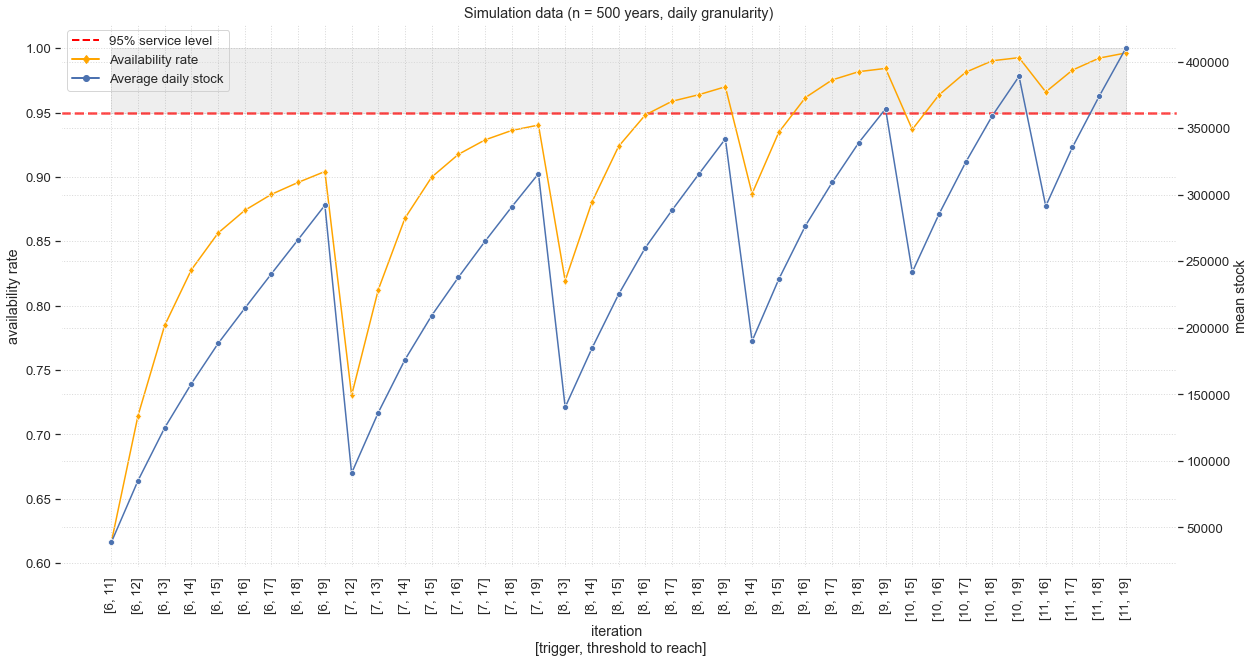

In [304]:
#Styling
sns.set(rc={"figure.figsize":(20, 10)}, font_scale = 1.2)
sns.set_style( {"axes.facecolor": "none",
                "grid.linestyle": ":",
                "grid.color" : "0.85",
                "axes.grid" : "True"})
sns.axes_style("ticks")
plt.xticks(rotation=90);

# 95% service level horizontal line
plt.axhline(0.95, ls='--',
            linewidth=2.5,
            color='red',
            alpha = 0.7
            )

# Setting the first y axis
sns.lineplot(x = x_axis,
             y = sim_data.availability_rate,
             color="orange",
             marker = "d"
             )
plt.xlabel("iteration \n [trigger, threshold to reach]")
plt.ylabel("availability rate")
plt.fill_between(x = x_axis, y1 = 0.95, y2 = 1, alpha=.13, color = "gray")

# Setting the second y axis
ax2 = plt.twinx()
sns.lineplot(x = x_axis,
             y = sim_data.mean_stock,
             ax=ax2,
             color = sns.color_palette()[0],
             marker = "o")

plt.ylabel("mean stock")

# Creating the plot
legend_elements = [plt.Line2D([0], [0], linestyle = "--",color='red', lw=2, label='95% service level'),
                   plt.Line2D([0], [0], marker = "d",color='orange', lw=2, label='Availability rate'),
                   plt.Line2D([0], [0], marker = "o", color=sns.color_palette()[0], lw=2, label='Average daily stock')]
plt.legend(handles=legend_elements, loc=0)

plt.title("Simulation data (n = 500 years, daily granularity)")

# Save the figure
plt.savefig("./first_level/simulation_results_visualization.pdf")

In [236]:
# Getting the best

sim_data[sim_data.availability_rate >= 0.95].sort_values(by = "price_per_percent_availability")

,iteration_tracking,availability_rate,mean_stock,price_per_percent_availability
26,"[9, 16]",0.961676,276695.710476,2877.22
31,"[10, 16]",0.963686,285310.879057,2960.62
21,"[8, 17]",0.958772,288287.196657,3006.84
35,"[11, 16]",0.966048,291380.120849,3016.21
27,"[9, 17]",0.975362,309192.022093,3170.02
22,"[8, 18]",0.963840,315315.665655,3271.45
32,"[10, 17]",0.981317,324302.184876,3304.76
36,"[11, 17]",0.982977,335605.838652,3414.18
28,"[9, 18]",0.981794,339164.485359,3454.54
23,"[8, 19]",0.970031,341917.870948,3524.81


In [255]:
third_sim.availability_rate = 1 - third_sim.availability_rate
third_sim["price_per_percent_availability"] = round(third_sim.mean_stock / (third_sim.availability_rate * 100),2)

In [256]:
third_sim

,iteration_tracking,availability_rate,mean_stock,price_per_percent_availability
0,"[8,16.0]",0.946434,257551.495249,2721.28
1,"[8,16.2]",0.949376,264609.599064,2787.20
2,"[8,16.4]",0.952197,270938.145909,2845.40
3,"[8,16.6]",0.954997,277387.138880,2904.59
4,"[8,16.8]",0.957134,283158.708409,2958.40
...,...,...,...,...
339,"[19,23.2]",0.999967,652810.444983,6528.32
340,"[19,23.4]",0.999984,662813.998902,6628.25
341,"[19,23.6]",1.000000,673619.781868,6736.20
342,"[19,23.8]",0.999956,682388.045261,6824.18


In [474]:
# tqdm

# Calculate the run time of a simulation based on the starting and ending points of the loops

tracking = list()
for trigger in range(14, 25):
    for goal in range(0, 40):
        if goal <= trigger + 15:
            continue
        tracking.append([trigger, goal])

len(tracking)*91/60/60
#tracking

1.390277777777778

### Your turn

Now that you are familiar with the provided simulation objects, use them to answer Elisa's requests on level 2.

In [13]:
# Your code goes in cells in this section

## Level 3

From the case description:

    - Right after you finished designing your policy for level 2, Elisa called
      with some news: she has just been informed by the management in Diemen
      that a new Minimum Order Quantity (MOQ) rule will begin soon. This rule
      means that, when the Caserta warehouse places an order to request
      material from, the order should be of at least 500,000 kgs of beans, and
      not less than that.
    - Elisa wants you to take this into account. Does it affect the policy you
      proposed for level 2? If so, you need to come up with a new one that
      adapts to this rule and compare it to the previous one.

In [342]:
def moq_purchase_policy(day,
                    current_stock,
                    ongoing_orders,
                    lead_time_generator,
                    po_trigger,
                    goal_stock
                    ):

    if ongoing_orders or current_stock > po_trigger:
        return None

    if current_stock <= po_trigger:
        amount_to_purchase = goal_stock - current_stock

        if amount_to_purchase < 500000:
            amount_to_purchase = 500000

        return PurchaseOrder(
            amount = amount_to_purchase,
            request_date = day,
            delivery_date = day + timedelta(days = lead_time_generator()),
        )

In [259]:
now = time.time()

mean_demand_quantity = demand.demand_quantity.mean()

tracking = list()
po_trigger_tracking = list()
goal_tracking = list()
mean_stock_tracking = list()
availability_rate_tracking = list()

for trigger in range(6, 12):
    for goal in range(11, 20):
        if goal <= trigger + 9: # The goal stock needs to account for at least the minimum lead time (4). All other simulations are trivial because the stock wouldn't be in the warehouse in time.
            continue
        simulation_config = SimulationConfig(
            starting_stock = stock.amount_in_stock.iloc[-1],
            demand_generator = lambda: generate_demand(1000, 110000),
            lead_time_generator = lambda: generate_lead_time(4,12),
            purchaser = moq_purchase_policy(),
            po_trigger = mean_demand_quantity * trigger,
            goal_stock = mean_demand_quantity * goal
        )


        simulation_setup = Simulation(
            config=simulation_config,
            verbose=False
        )
        example_simulation_results = simulation_setup.run()

        tracking.append("[" + f"{trigger}" +"," + f"{goal}" + "]")
        po_trigger_tracking.append(trigger)
        goal_tracking.append(goal)
        example_simulation_results_sliced = example_simulation_results.stock_states[21:]
        mean_stock_tracking.append(example_simulation_results_sliced.mean())
        availability_rate_tracking.append( 1 - len(example_simulation_results_sliced[example_simulation_results_sliced < 0]) / len(example_simulation_results.stock_states))

sim_run_time = time.time() - now

second_level_first_sim = pd.DataFrame({
    "iteration_tracking" : tracking,
    "availability_rate" : availability_rate_tracking,
    "mean_stock" : mean_stock_tracking,
})

second_level_first_sim.to_csv("./second_level/first_sim.csv", index = False)
(sim_run_time / 60) / 60

0.9569608491659165

In [365]:
sim_data = second_level_first_sim.copy()
sim_data

,iteration_tracking,availability_rate,mean_stock
0,"[6,11]",0.860383,196517.264496
1,"[6,12]",0.862575,197953.523812
2,"[6,13]",0.862843,198733.956859
3,"[6,14]",0.861599,197220.429528
4,"[6,15]",0.864520,199517.567457
5,"[6,16]",0.872365,213900.142997
6,"[6,17]",0.885783,240245.985030
7,"[6,18]",0.895420,265755.042986
8,"[6,19]",0.903463,291318.812198
9,"[7,12]",0.920458,247224.376228


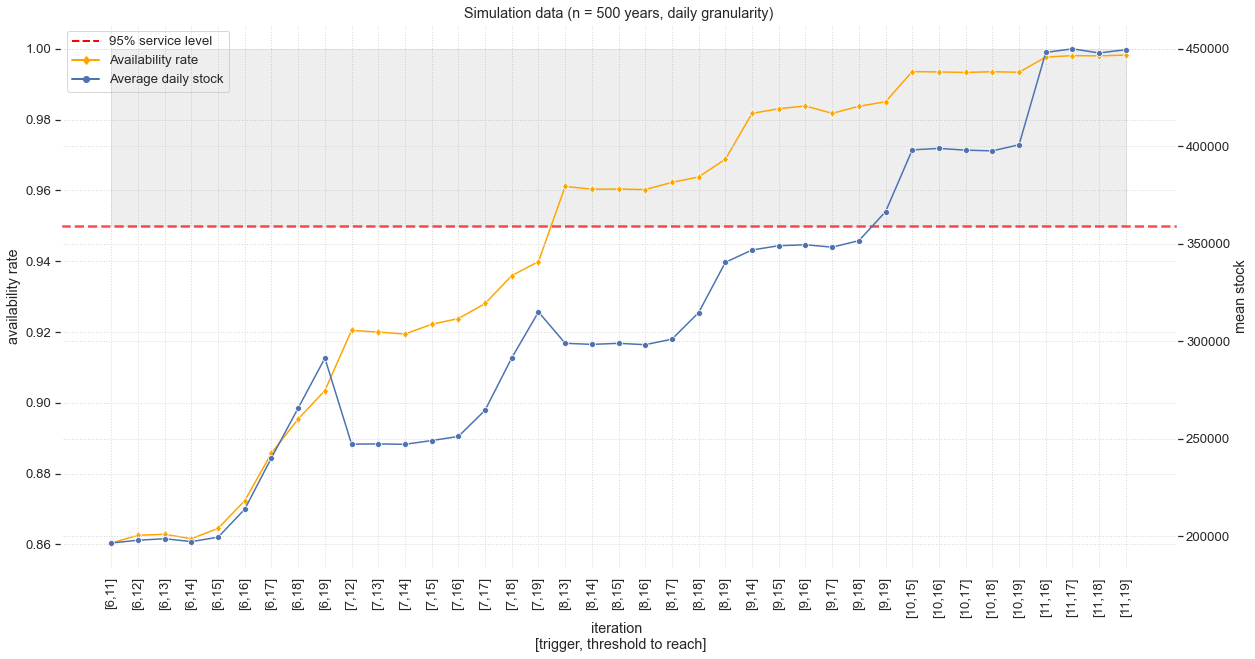

In [367]:
#Styling
sns.set(rc={"figure.figsize": (20, 10)}, font_scale=1.2)
sns.set_style({"axes.facecolor": "none",
               "grid.linestyle": ":",
               "grid.color": "0.85",
               "axes.grid": "True"})
sns.axes_style("ticks")
plt.xticks(rotation=90);

# 95% service level horizontal line
plt.axhline(0.95, ls='--',
            linewidth=2.5,
            color='red',
            alpha=0.7
            )

# Setting the first y axis
sns.lineplot(x=sim_data.iteration_tracking,
             y=sim_data.availability_rate,
             color="orange",
             marker="d"
             )
plt.xlabel("iteration \n [trigger, threshold to reach]")
plt.ylabel("availability rate")
plt.fill_between(x = sim_data.iteration_tracking, y1 = 0.95, y2 = 1, alpha=.13, color = "gray")

# Setting the second y axis
ax2 = plt.twinx()
sns.lineplot(x=sim_data.iteration_tracking,
             y=sim_data.mean_stock,
             ax=ax2,
             color=sns.color_palette()[0],
             marker="o")

plt.ylabel("mean stock")
# Creating the plot
legend_elements = [plt.Line2D([0], [0], linestyle="--", color='red', lw=2, label='95% service level'),
                   plt.Line2D([0], [0], marker="d", color='orange', lw=2, label='Availability rate'),
                   plt.Line2D([0], [0], marker="o", color=sns.color_palette()[0], lw=2, label='Average daily stock')]
plt.legend(handles=legend_elements, loc=0)

plt.title("Simulation data (n = 500 years, daily granularity)")

# Save the figure
plt.savefig("./second_level/simulation_results_visualization.pdf")

In [410]:
second_level_first_sim["price_per_sl"] = second_level_first_sim.mean_stock / (second_level_first_sim.availability_rate * 100)
second_level_first_sim[second_level_first_sim.availability_rate >= 0.945]

,iteration_tracking,availability_rate,mean_stock,price_per_sl
17,"[8,13]",0.961133,298945.914881,3110.348312
18,"[8,14]",0.960350,298387.780897,3107.074015
19,"[8,15]",0.960388,298922.532103,3112.518012
20,"[8,16]",0.960240,298226.153567,3105.745377
21,"[8,17]",0.962273,301054.196838,3128.574206
22,"[8,18]",0.963796,314717.234679,3265.392802
23,"[8,19]",0.968831,340466.699469,3514.201188
24,"[9,14]",0.981761,346795.865686,3532.385832
25,"[9,15]",0.983087,348980.622859,3549.845195
26,"[9,16]",0.983859,349475.994860,3552.092889


In [475]:
now = time.time()

mean_demand_quantity = demand.demand_quantity.mean()

tracking = list()
po_trigger_tracking = list()
goal_tracking = list()
mean_stock_tracking = list()
availability_rate_tracking = list()
micro_data = list()

for trigger in range(14, 25):
    for goal in range(0, 40):
        if goal <= trigger + 15: # The goal stock needs to account for at least the minimum lead time (4). All other simulations are trivial because the stock wouldn't be in the warehouse in time.
            continue
        simulation_config = SimulationConfig(
            starting_stock = stock.amount_in_stock.iloc[-1],
            demand_generator = lambda: generate_demand(1000, 110000),
            lead_time_generator = lambda: 15,

            # The purchase policy is changed to account for the MOQ rule
            purchaser = moq_purchase_policy,

            po_trigger = mean_demand_quantity * trigger,
            goal_stock = mean_demand_quantity * goal
        )


        simulation_setup = Simulation(
            config=simulation_config,
            verbose=False
        )
        example_simulation_results = simulation_setup.run()


        tracking.append("[" + f"{trigger}" +"," + f"{goal}" + "]")
        po_trigger_tracking.append(trigger)
        goal_tracking.append(goal)
        example_simulation_results_sliced = example_simulation_results.stock_states[21:]
        mean_stock_tracking.append(example_simulation_results_sliced.mean())
        availability_rate_tracking.append( 1 - len(example_simulation_results_sliced[example_simulation_results_sliced < 0]) / len(example_simulation_results.stock_states))
        micro_data.append(simulation_setup.results.stock_states)

sim_run_time = time.time() - now

third_simulation = pd.DataFrame({
    "iteration_tracking" : tracking,
    "availability_rate" : availability_rate_tracking,
    "mean_stock" : mean_stock_tracking,
})

third_simulation.to_csv("./third_level/first_sim.csv", index = False)
(sim_run_time / 60) / 60

1.361383710834715

In [488]:
sim_data = third_level_all_sim.copy()
sim_data

,iteration_tracking,availability_rate,mean_stock
0,"[14,25]",0.702549,150444.7273
1,"[14,26]",0.770624,201488.3788
2,"[14,27]",0.829959,248357.9288
3,"[14,28]",0.883142,294924.7948
4,"[14,29]",0.916306,333317.2315
...,...,...,...
70,"[21,38]",1.000000,740497.9239
71,"[21,39]",1.000000,765461.5712
72,"[22,38]",1.000000,764298.1311
73,"[22,39]",1.000000,790050.1180


In [492]:
third_level_all_sim["price_per_sl"] = third_level_all_sim.mean_stock / third_level_all_sim.availability_rate * 100
third_level_all_sim[third_level_all_sim.availability_rate > 0.94]

,iteration_tracking,availability_rate,mean_stock,price_per_sl
8,"[14,33]",0.943283,439741.7874,4.661821e+07
9,"[14,34]",0.944763,463873.4689,4.909948e+07
10,"[14,35]",0.948466,490262.8999,5.169008e+07
11,"[14,36]",0.949803,513672.5135,5.408200e+07
12,"[14,37]",0.952668,540124.7448,5.669598e+07
13,"[14,38]",0.954476,565059.4073,5.920098e+07
14,"[14,39]",0.955748,589776.6289,6.170841e+07
19,"[15,30]",0.961632,382952.9983,3.982325e+07
20,"[15,31]",0.970946,413094.0958,4.254554e+07
21,"[15,32]",0.974211,439611.7031,4.512489e+07


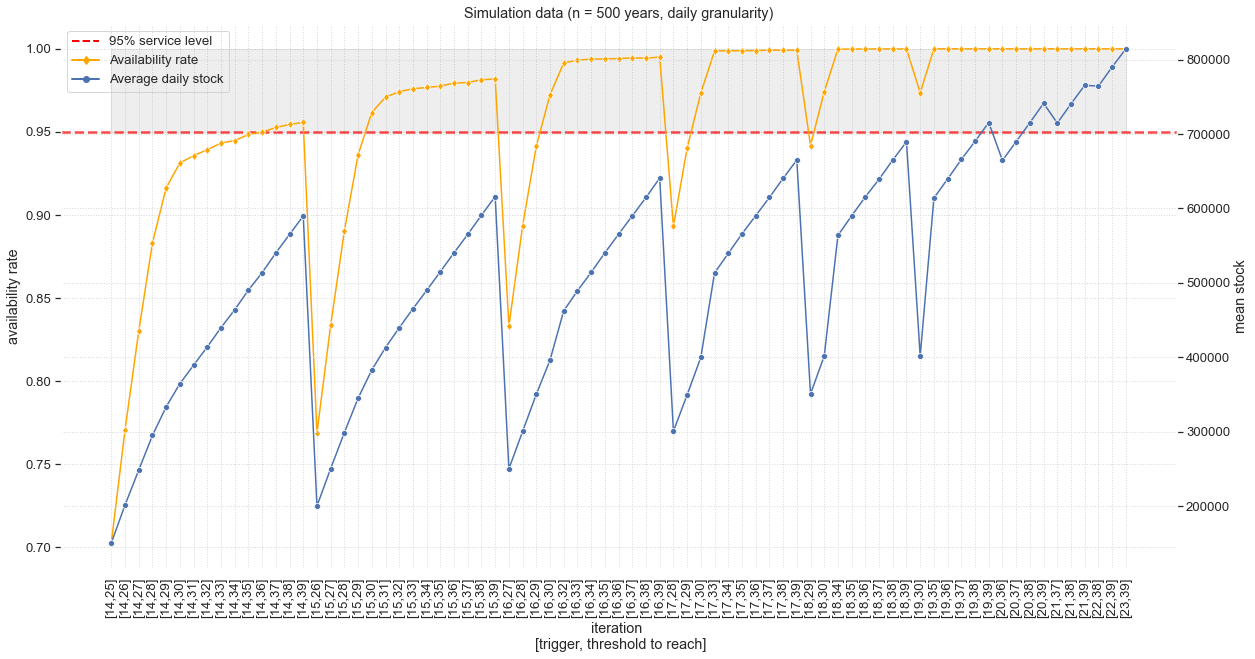

In [489]:
#Styling
sns.set(rc={"figure.figsize": (20, 10)}, font_scale=1.2)
sns.set_style({"axes.facecolor": "none",
               "grid.linestyle": ":",
               "grid.color": "0.85",
               "axes.grid": "True"})
sns.axes_style("ticks")
plt.xticks(rotation=90);

# 95% service level horizontal line
plt.axhline(0.95, ls='--',
            linewidth=2.5,
            color='red',
            alpha=0.7
            )

# Setting the first y axis
sns.lineplot(x=sim_data.iteration_tracking,
             y=sim_data.availability_rate,
             color="orange",
             marker="d"
             )
plt.xlabel("iteration \n [trigger, threshold to reach]")
plt.ylabel("availability rate")
plt.fill_between(x = sim_data.iteration_tracking, y1 = 0.95, y2 = 1, alpha=.13, color = "gray")

# Setting the second y axis
ax2 = plt.twinx()
sns.lineplot(x=sim_data.iteration_tracking,
             y=sim_data.mean_stock,
             ax=ax2,
             color=sns.color_palette()[0],
             marker="o")

plt.ylabel("mean stock")
# Creating the plot
legend_elements = [plt.Line2D([0], [0], linestyle="--", color='red', lw=2, label='95% service level'),
                   plt.Line2D([0], [0], marker="d", color='orange', lw=2, label='Availability rate'),
                   plt.Line2D([0], [0], marker="o", color=sns.color_palette()[0], lw=2, label='Average daily stock')]
plt.legend(handles=legend_elements, loc=0)

plt.title("Simulation data (n = 500 years, daily granularity)")

# Save the figure
plt.savefig("./third_level/simulation_results_visualization.pdf")